In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tvF
from torchvision.utils import make_grid
import json
import struct
import pickle

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tvF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

cnn = Net()
cnn.load_state_dict(torch.load('mnist_cnn.pt'))
img = torch.arange(1 * 28 * 28,dtype=torch.float).reshape(1,1,28,28)
output = cnn(img)
output

tensor([[-229.1328, -314.3718, -199.2065, -102.0735, -343.1923,  -72.6965,
         -127.6820, -392.0713,    0.0000, -324.5445]],
       grad_fn=<LogSoftmaxBackward0>)

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

In [4]:
dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

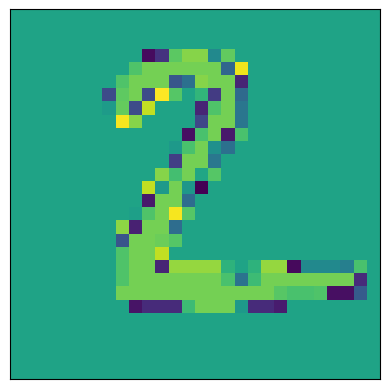

In [17]:
batch,_ = dataset[1]
show(batch)

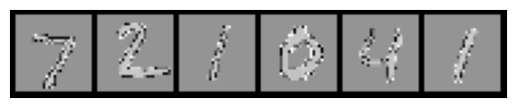

In [6]:
batches = [dataset[i][0] for i in range(6)]
show(make_grid(batches))

In [7]:
for i in range(6):
    output = cnn(batches[i].reshape(1,1,28,28))
    print(output.argmax())

tensor(7)
tensor(2)
tensor(1)
tensor(0)
tensor(4)
tensor(1)


In [8]:
sd = cnn.state_dict()
print(dict(sd))

{'conv1.weight': tensor([[[[ 0.2437, -0.1792, -0.2372],
          [ 0.1540, -0.3400,  0.2281],
          [-0.1094,  0.1883,  0.1041]]],


        [[[-0.0923,  0.0784,  0.0795],
          [ 0.0619, -0.2485, -0.1691],
          [-0.0947,  0.0371, -0.0604]]],


        [[[ 0.3992,  0.1737, -0.1872],
          [-0.1718, -0.2030, -0.3402],
          [-0.0712,  0.0430,  0.3366]]],


        [[[ 0.1842, -0.2826,  0.2418],
          [ 0.0259,  0.3166,  0.2711],
          [-0.4913, -0.4823, -0.2557]]],


        [[[ 0.1897, -0.0297,  0.2909],
          [-0.1607,  0.3256, -0.2269],
          [ 0.2387, -0.0740, -0.4183]]],


        [[[ 0.1172, -0.1426,  0.1492],
          [-0.1722, -0.1703, -0.3664],
          [-0.1950,  0.0671, -0.0371]]],


        [[[ 0.3034,  0.1918, -0.1041],
          [-0.2917,  0.1266,  0.0214],
          [-0.3171,  0.1292,  0.1755]]],


        [[[ 0.5066, -0.1909, -0.2690],
          [ 0.1129,  0.0306, -0.3823],
          [-0.2179,  0.2075, -0.0241]]],


        [[[ 0.2

In [9]:
for param_tensor in cnn.state_dict():
    t = cnn.state_dict()[param_tensor]
    print(param_tensor, "\t", t.size())


conv1.weight 	 torch.Size([32, 1, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 9216])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])


In [10]:
sd = cnn.state_dict()
kernel = sd['conv1.weight']
print(pickle.dumps(kernel))

b'\x80\x04\x95\t\x06\x00\x00\x00\x00\x00\x00\x8c\x0ctorch._utils\x94\x8c\x12_rebuild_tensor_v2\x94\x93\x94(\x8c\rtorch.storage\x94\x8c\x10_load_from_bytes\x94\x93\x94Bt\x05\x00\x00\x80\x02\x8a\nl\xfc\x9cF\xf9 j\xa8P\x19.\x80\x02M\xe9\x03.\x80\x02}q\x00(X\x10\x00\x00\x00protocol_versionq\x01M\xe9\x03X\r\x00\x00\x00little_endianq\x02\x88X\n\x00\x00\x00type_sizesq\x03}q\x04(X\x05\x00\x00\x00shortq\x05K\x02X\x03\x00\x00\x00intq\x06K\x04X\x04\x00\x00\x00longq\x07K\x04uu.\x80\x02(X\x07\x00\x00\x00storageq\x00ctorch\nFloatStorage\nq\x01X\n\x00\x00\x004789127264q\x02X\x03\x00\x00\x00cpuq\x03M \x01Ntq\x04Q.\x80\x02]q\x00X\n\x00\x00\x004789127264q\x01a. \x01\x00\x00\x00\x00\x00\x00\xea\x92y>{u7\xbeF\xe5r\xbe\xfe\xa7\x1d>\x9f\x19\xae\xbe\x0b\x8ci>\xb5\xfb\xdf\xbd\xcd\xda@>@2\xd5=\xa7\x00\xbd\xbd*\xaa\xa0=\x04\xe8\xa2=\xff\x82}=\xcbv~\xbe\xe1\x1c-\xber\xdb\xc1\xbdS\xd0\x17=\xed\x89w\xbd\xf3e\xcc>\x1f\xd31>\x8f\xba?\xbea\xe1/\xbeM\xd3O\xbeD(\xae\xbe\xa0\xc2\x91\xbd\xd5\n0=RU\xac>6\xa7<>c\xac\x90\xb

In [11]:
kernel.numpy().dtype == 'float64'

False

In [12]:
np_kernel = kernel.numpy()
pickle.dumps(np_kernel)
# print(json.dumps(np_kernel.tolist(),indent=2))

b'\x80\x04\x95\x13\x05\x00\x00\x00\x00\x00\x00\x8c\x16numpy._core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01(K K\x01K\x03K\x03t\x94h\x03\x8c\x05dtype\x94\x93\x94\x8c\x02f4\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\x80\x04\x00\x00\xea\x92y>{u7\xbeF\xe5r\xbe\xfe\xa7\x1d>\x9f\x19\xae\xbe\x0b\x8ci>\xb5\xfb\xdf\xbd\xcd\xda@>@2\xd5=\xa7\x00\xbd\xbd*\xaa\xa0=\x04\xe8\xa2=\xff\x82}=\xcbv~\xbe\xe1\x1c-\xber\xdb\xc1\xbdS\xd0\x17=\xed\x89w\xbd\xf3e\xcc>\x1f\xd31>\x8f\xba?\xbea\xe1/\xbeM\xd3O\xbeD(\xae\xbe\xa0\xc2\x91\xbd\xd5\n0=RU\xac>6\xa7<>c\xac\x90\xbe\x81\xa3w>Z\x89\xd4<%\x19\xa2>5\xd3\x8a>\xfd\x8f\xfb\xbe\x08\xea\xf6\xbe\xda\xe6\x82\xbe#MB>\xb6\r\xf3\xbc\x85\xf3\x94>2\x8d$\xbe\xba\xaf\xa6>\xbc[h\xbe\xdeyt>\xc0\x80\x97\xbd\x95&\xd6\xbeA\x07\xf0=\x1a\x02\x12\xbe\xa0\xcc\x18><S0\xbefl.\xbe\x14\x98\xbb\xbe\xaa\xa4G\xbe\x87`\x89=\xa7\xe0\x17\xbd\xd0W\x9b

In [13]:
from chpl_tensor import *
ct = ChapelTensor(np.arange(15).reshape(3,5).astype('float32'))

# import io
# f = io.BytesIO()
# p = MyPickler(f)
# p.dump(ct)
# bts = f.getvalue()
# print(str(bts))
ct.__dict__

{'rank': 2,
 'shape': (3, 5),
 'dtype': 'float32',
 'data': array([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]], dtype=float32)}

In [14]:
byte_str = pickle.dumps(ct)
str_of_bytes = str(byte_str,encoding='latin1')
ct1 = pickle.loads(bytes(str_of_bytes,'latin1'))
ct1.data.__dict__


AttributeError: 'numpy.ndarray' object has no attribute '__dict__'

In [ ]:

json.dumps(ct.full_dict())

'{"rank": 2, "shape": [3, 5], "dtype": "float32", "data": [[0.0, 1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0, 9.0], [10.0, 11.0, 12.0, 13.0, 14.0]]}'

In [ ]:
import io
bf = io.StringIO()
pickle.dump(ct,bf)

TypeError: string argument expected, got 'bytes'

In [16]:
import chpl_tensor as ct

# for i in range(6):
#     output = cnn(batches[i].reshape(1,1,28,28))
#     print(output.argmax())

for param_tensor in cnn.state_dict():
    print("Serializing ", param_tensor)
    t = cnn.state_dict()[param_tensor]
    t = ct.ChapelTensor(t.to(torch.float64))
    t_json = json.dumps(t.full_dict(),indent=2)
    # t_bytes = t.pack_bytes()
    path = '../data/models/mnist_cnn/' + param_tensor

    print("Writing json.")
    f = open(path + '.json', 'w+')
    f.write(t_json)
    f.close()

    print("Writing bytes.")
    f = open(path + '.chdata','wb')
    t.pack_into(f)
    f.close()

for i in range(20000):
    img_,lb = dataset[i]
    img = img_.reshape(1,1,28,28)
    t = ct.ChapelTensor(img.reshape(1,28,28).to(torch.float64))
    t_json = json.dumps(t.full_dict(),indent=2)
    # t_bytes = t.pack_bytes()
    output = int(cnn(img).argmax())
    path = '../data/datasets/mnist/image_idx_' + str(i) # + f'_{lb}_{output}'
    print(i, output)
    # print("Writing json.", i)
    f = open(path + '.json', 'w+')
    f.write(t_json)
    f.close()

    # print("Writing bytes.")
    f = open(path + '.chdata','wb')
    t.pack_into(f)
    f.close()


Serializing  conv1.weight
Writing json.
Writing bytes.
Serializing  conv1.bias
Writing json.
Writing bytes.
Serializing  conv2.weight
Writing json.
Writing bytes.
Serializing  conv2.bias
Writing json.
Writing bytes.
Serializing  fc1.weight
Writing json.
Writing bytes.
Serializing  fc1.bias
Writing json.
Writing bytes.
Serializing  fc2.weight
Writing json.
Writing bytes.
Serializing  fc2.bias
Writing json.
Writing bytes.
0 7
1 2
2 1
3 0
4 4
5 1
6 4
7 9
8 5
9 9
10 0
11 6
12 9
13 0
14 1
15 5
16 9
17 7
18 3
19 4
20 9
21 6
22 6
23 5
24 4
25 0
26 7
27 4
28 0
29 1
30 3
31 1
32 3
33 4
34 7
35 2
36 7
37 1
38 2
39 1
40 1
41 7
42 4
43 2
44 3
45 5
46 1
47 2
48 4
49 4
50 6
51 3
52 5
53 5
54 6
55 0
56 4
57 1
58 9
59 5
60 7
61 8
62 5
63 3
64 7
65 4
66 6
67 4
68 3
69 0
70 7
71 0
72 2
73 9
74 1
75 7
76 3
77 2
78 9
79 7
80 7
81 6
82 2
83 7
84 8
85 4
86 7
87 3
88 6
89 1
90 3
91 6
92 9
93 3
94 1
95 4
96 1
97 7
98 6
99 9
100 6
101 0
102 5
103 4
104 9
105 9
106 2
107 1
108 9
109 4
110 8
111 7
112 3
113 9
11

IndexError: index 10000 is out of bounds for dimension 0 with size 10000

In [ ]:
batched_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

In [ ]:
img,lb = batched_dataset
img.shape

torch.Size([1, 28, 28])

In [ ]:
batched_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [ ]:
for i in range(1000):
    img_,lb = dataset[i]
    img = img_.reshape(1,1,28,28)
    # t_bytes = t.pack_bytes()
    output = int(cnn(img).argmax())
    path = '../data/datasets/mnist/image_idx_' + str(i) # + f'_{lb}_{output}'
    print(i, output)

0 7
1 2
2 1
3 0
4 4
5 1
6 4
7 9
8 5
9 9
10 0
11 6
12 9
13 0
14 1
15 5
16 9
17 7
18 3
19 4
20 9
21 6
22 6
23 5
24 4
25 0
26 7
27 4
28 0
29 1
30 3
31 1
32 3
33 4
34 7
35 2
36 7
37 1
38 2
39 1
40 1
41 7
42 4
43 2
44 3
45 5
46 1
47 2
48 4
49 4
50 6
51 3
52 5
53 5
54 6
55 0
56 4
57 1
58 9
59 5
60 7
61 8
62 5
63 3
64 7
65 4
66 6
67 4
68 3
69 0
70 7
71 0
72 2
73 9
74 1
75 7
76 3
77 2
78 9
79 7
80 7
81 6
82 2
83 7
84 8
85 4
86 7
87 3
88 6
89 1
90 3
91 6
92 9
93 3
94 1
95 4
96 1
97 7
98 6
99 9
100 6
101 0
102 5
103 4
104 9
105 9
106 2
107 1
108 9
109 4
110 8
111 7
112 3
113 9
114 7
115 4
116 4
117 4
118 9
119 2
120 5
121 4
122 7
123 6
124 7
125 9
126 0
127 5
128 8
129 5
130 6
131 6
132 5
133 7
134 8
135 1
136 0
137 1
138 6
139 4
140 6
141 7
142 3
143 1
144 7
145 1
146 8
147 2
148 0
149 2
150 9
151 9
152 5
153 5
154 1
155 5
156 6
157 0
158 3
159 4
160 4
161 6
162 5
163 4
164 6
165 5
166 4
167 5
168 1
169 4
170 4
171 7
172 2
173 3
174 2
175 7
176 1
177 8
178 1
179 8
180 1
181 8
182 5
183 0
184 8


In [ ]:
torch.set_default_device('cpu')

In [ ]:
cnn.to('cpu')

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

AttributeError: 'Net' object has no attribute 'dtype'